## Load the processed version of the data file

In [1]:
import time
import sys
import numpy as np
import pandas as pd

In [2]:
#takes about 40 secs to load
path = 'data/processed/LoanStats-combined-z-2.csv'
t1 = time.time()
df = pd.read_csv(path)
t2 = time.time()
print "{} bytes loaded in {:0.3f} secs".format(sys.getsizeof(df),t2-t1)
print df.shape


/Users/stephane/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (19,47,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2073973247 bytes loaded in 24.780 secs
(887382, 147)


## Finally, create a list of features for fitting a model

As a first pass, I'm only pulling out numeric features. Text processing can be added later.

In [3]:
# I spent an unnecessary amount of time figuring out how to do this, and it turns out there's  a builtin for it...
num_cols=list(df._get_numeric_data().columns) 
# remove cols we won't use for model fitting
rem_cols = ['lc_id', 'member_id', 'loan_status_num', 'grade_num']
for r in rem_cols:
    num_cols.remove(r)
#print num_cols
print len(num_cols)
print num_cols

118
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', '

## Need to avoid using some features that represent information gained after the loan status

In [37]:
skippers = [
    'collection_recovery_fee',
    'out_prncp',
    'out_prncp_inv',
    'pymnt_plan',
    'recoveries',
    'sub_grade',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp'
    ]
for r in skippers:
    if r in num_cols:
        num_cols.remove(r)
    

## Conservative list of features that I may want to use?

In [46]:
# naw, do this later
'acc_now_delinq'
'acc_open_past_24mths'
'addr_state'

'addr_state'

## After all that, finally ready to try to fit something?

In [4]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics


### Initially, downsample the DataFrame for quicker testing

In [39]:
minidf=df.sample(n=10000,random_state=33)
minidf.sort_values(by='grade_num',inplace=True)
print df.shape
print minidf.shape

(887382, 147)
(10000, 147)


### NaNs are a problem, so one more filtering step:

In [40]:
validindexlist=(minidf.loan_status_num ==1) | (minidf.loan_status_num == 0)
#X = df[num_cols][validindexlist].fillna(0)
#X = pd.DataFrame(minidf['grade_num'][validindexlist].fillna(0)) # just grade num, like before
#X = pd.DataFrame(
#    df[(list(['grade_num'])+num_cols)[0:10]][validindexlist].fillna(0)) # new vals + grade_num
# X = pd.DataFrame(minidf[num_cols[0:10]][validindexlist].fillna(0)) # just a few new features
X = minidf[num_cols][validindexlist].fillna(0)
y = minidf.loan_status_num[validindexlist].fillna(0)
print type(X) ,X.shape
print type(y), y.shape
print 'done'

<class 'pandas.core.frame.DataFrame'> (9742, 109)
<class 'pandas.core.series.Series'> (9742,)
done


### Now train, test, split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=22)
logreg2 = LogisticRegression()
logreg2.fit(X_train,y_train)
y_pred_class = logreg2.predict(X_test)
y_pred_prob = logreg2.predict_proba(X_test)[:,1]

## Okay, how did the model do?

In [41]:
print "percent of loans successful in y_test: {}/{} = {}".format(
    y_test[y_test == 1].count(), y_test.count(),
    float(y_test[y_test == 1].count())/ y_test.count() )
print "percent of loans predicted to be successful: {}/{} = {}".format(
    y_pred_class.sum() , len(y_pred_class),
    float(y_pred_class.sum())/len(y_pred_class))
                                                                 
a = [i for i,x in enumerate(y_pred_class) if x != 1] # false predictions
#print len(a), a
#print logreg2.classes_
#print y_pred_prob[a]
#print y_pred_prob[0:3]

print 'done'

percent of loans successful in y_test: 2285/2436 = 0.938013136289
percent of loans predicted to be successful: 2424.0/2436 = 0.995073891626
done


### (this will be a good spot for a confusion matrix)

In [42]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print confusion
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]
print 'True Positives:', TP
print 'True Negatives:', TN
print 'False Positives:', FP
print 'False Negatives:', FN
# calculate the sensitivity
print TP / float(TP + FN)
# calculate the specificity
print TN / float(TN + FP)

[[   4  147]
 [   8 2277]]
True Positives: 2277
True Negatives: 4
False Positives: 147
False Negatives: 8
0.996498905908
0.0264900662252


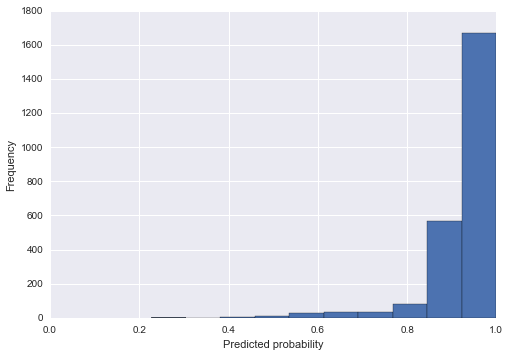

In [43]:
plt.hist(y_pred_prob)
plt.xlim(0, 1)
plt.xlabel('Predicted probability')
plt.ylabel('Frequency')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1221419d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x119480910>], dtype=object)

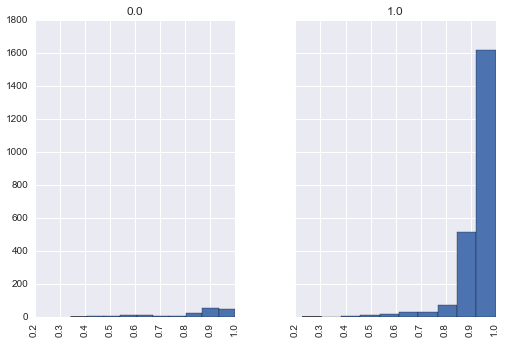

In [44]:
tempdf = pd.DataFrame({'probability':y_pred_prob, 'actual':y_test})
tempdf.hist(column='probability', by='actual', sharex=True, sharey=True)

0.734876171983


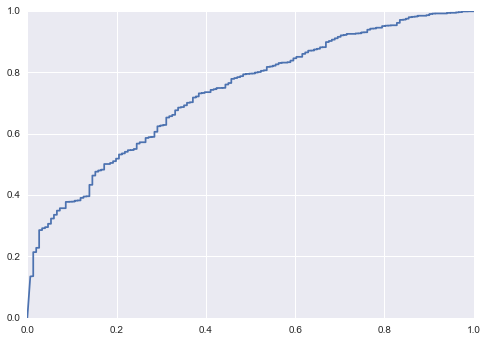

In [45]:
# ROC curve 
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
print metrics.roc_auc_score(y_test, y_pred_prob)

### To check results of the fit, plot the predicted probabilities

This was a first attempt to view a correlation between the predicted probabilities and the outcomes of the loans. I hoped to see more 'defaults' (black points) toward the left, at the lower probabilities. However this graph didn't work very well.

/Users/stephane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


<class 'pandas.core.series.Series'>
2436 2436
1.0 0.0
(2436,) (2436,) 2436 (2436,)


/Users/stephane/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


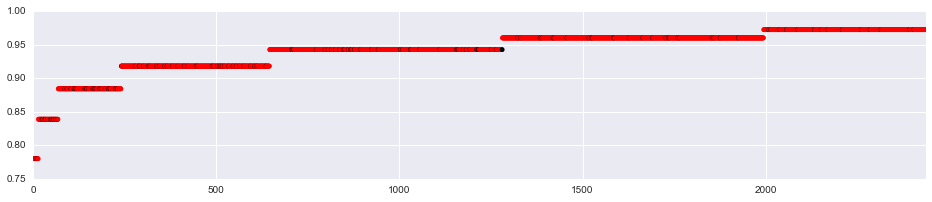

In [13]:
sis = y_pred_prob.argsort()
colormap = np.array(['k', 'r'])
plt.figure(figsize=(16, 3))
plt.scatter(range(len(y_pred_prob)),y_pred_prob[sis],color=colormap[list(y_test.iloc[sis])])
plt.xlim([0,len(y_test)])
#plt.scatter(range(len(y_test)),y_test.iloc[sis],color=colormap[list(y_test.iloc[sis])])
print type(y_test)

print len(y_test),len(sis)
print max(y_test),min(y_test)
print y_test.shape,sis.shape,len(y_test[sis]),y_test[sis].shape

### Second attempt to evaluate the model graphically

This graph shows a boxplot of predicted probabilities broken down into 2 groups based on outcome. It is clear that 'successful' loans (loan_status_num ==1) have a higher distribution of predicted probabilites than 'unsuccessful' loans (loan_status_num == 0).

1.0    2285
0.0     151
Name: loan_status_num, dtype: int64


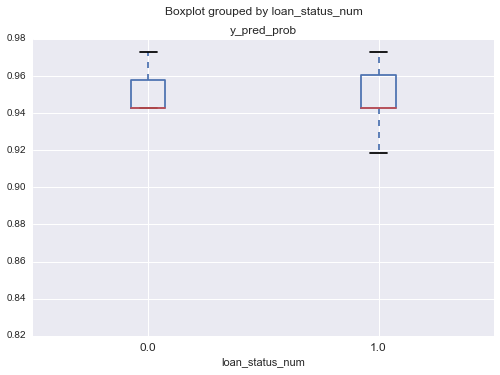

In [14]:
# merge these things into a single dataframe for plotting:
testdf=pd.concat([X_test,y_test,pd.DataFrame(y_pred_prob,columns=['y_pred_prob'])],axis=1)
testdf.boxplot(column='y_pred_prob',by='loan_status_num')
print testdf.loan_status_num.value_counts()

In [15]:
grouped = testdf.groupby('loan_status_num')
grouped.y_pred_prob.quantile([.25, .5, .75, 1])


loan_status_num      
0.0              0.25    0.942907
                 0.50    0.942907
                 0.75    0.957808
                 1.00    0.972709
1.0              0.25    0.942907
                 0.50    0.942907
                 0.75    0.960415
                 1.00    0.972709
dtype: float64

In [16]:
#plt.scatter(df.grade_num,df.loan_status_num,label='loan status')
#plt.plot(df2.grade_num,df2.loan_status_pred_num,color='red')
#plt.plot(X_test['grade_num'].sort_values(),y_pred_class,color='red')
#plt.setp(plt.gca(), xticklabels=gradenames, xticks = gradenums)
#plt.setp(plt.gca(), yticklabels=np.arange(0,1.2,.2), yticks = np.arange(0,1.2,.2))
#plt.setp(plt.gca(),title = 'Predicted loan status, test set')

## next...

In [17]:
print 'done'

done


In [47]:
#print total_success_rate
print "percent of loans successful in y_test: {}/{} = {}".format(y_test[y_test == 1].count(), y_test.count(),
                                                       float(y_test[y_test == 1].count())/ y_test.count() )
print "logreg class prediction accuracy:" , metrics.accuracy_score(y_test, y_pred_class)
print "guess all successful accuracy: ", metrics.accuracy_score(y_test,[1]*len(y_test))

percent of loans successful in y_test: 2285/2436 = 0.938013136289
logreg class prediction accuracy: 0.936371100164
guess all successful accuracy:  0.938013136289


In [48]:
grouped=minidf.groupby('grade')
probs=grouped.loan_status_num.sum()/grouped.loan_status_num.count()
print probs

grade
A    0.973794
B    0.964311
C    0.944033
D    0.906397
E    0.874317
F    0.839827
G    0.830508
Name: loan_status_num, dtype: float64


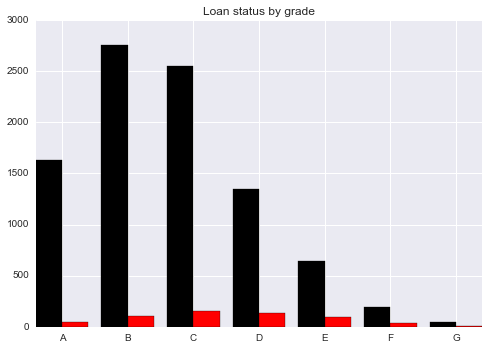

In [49]:
fig,ax = plt.subplots()
width=.4
xlocs=np.arange(0,7)
ax.bar(xlocs-width,grouped.loan_status_num.sum(),width,color='k')
ax.set_xticks(xlocs)
ax.set_xticklabels(sorted(minidf.grade.unique()))
ax.bar(
        xlocs,grouped.loan_status_num.apply(lambda item: (item == 0).sum()),width,
        color='r')
ax.set_title('Loan status by grade')

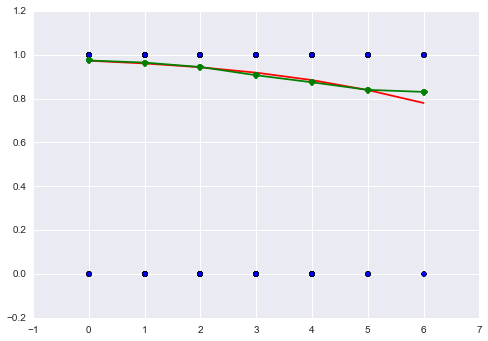

In [21]:
#df2['loan_status_pred_prob']=logreg.predict_proba(X)[:,1]
plt.scatter(minidf.grade_num,minidf.loan_status_num)
#plt.plot(df2.grade_num,df2.loan_status_pred_prob,color='red')
X_test_s=X_test.sort_values(by='grade_num').grade_num.reshape(-1,1)
plt.plot(X_test_s,logreg2.predict_proba(X_test_s)[:,1],color='red')

plt.plot(probs,'go-')